# 4.4.5 Challenge: Build your own NLP model
__Instructions__
For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.


In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# NLP 
import spacy
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

### Corpus Processing - PLOS Abstracts
The corpus I decided to use for this challenge is from PLOS searches.  PLOS is a non-profit publisher of scientific articles. I pulled abstract searches from the PLOS API with the following title searches: cancer, HIV, and heart disease.

In [2]:
response1 = requests.get(r'http://api.plos.org/search?q=title:"cancer"&fl=abstract&wt=json&api_key=51bQhx63o6--UjRBhkHb')
response2 = requests.get(r'http://api.plos.org/search?q=title:"HIV"&fl=abstract&wt=json&api_key=51bQhx63o6--UjRBhkHb')
response3 = requests.get(r'http://api.plos.org/search?q=title:"heart disease"&fl=abstract&wt=json&api_key=51bQhx63o6--UjRBhkHb')

Pulling JSON data into usable data

In [3]:
cancer_raw = response1.json()
hiv_raw = response2.json()
heart_raw = response3.json()

Pulling out just the abstracts of each article into one string. 

In [4]:
cancer = ''
for article in cancer_raw['response']['docs']:
    art = re.sub(r'[\[\]]','', str(article['abstract']))
    cancer = cancer + art

cancer[0:200]

"'\\nSocietal perceptions may factor into the high rates of nontreatment in patients with lung cancer. To determine whether bias exists toward lung cancer, a study using the Implicit Association Test me"

In [5]:
hiv = ''
for article in hiv_raw['response']['docs']:
    art = re.sub(r'[\[\]]','', str(article['abstract']))
    hiv = hiv + art

hiv[0:200]

"'Background: Whether spontaneous low levels of HIV-1 RNA in blood plasma correlate with low levels of HIV-1 RNA in seminal plasma has never been investigated in HIV controller (HIC) men so far. Method"

In [6]:
heart = ''
for article in heart_raw['response']['docs']:
    art = re.sub(r'[\[\]]','', str(article['abstract']))
    heart = heart + art

heart[0:200]

"'\\nThere are 16.5 million newborns in China annually. However, the incidence of congenital heart disease (CHD) has not been evaluated. In 2004, we launched an active province-wide hospital-based CHD r"

### Text Cleaning
Removing --, which is not processed by our NLP models; removing excess quotation marks, and removing all digits.

In [7]:
def text_cleaner(text):
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'[\']', '', text)
    text = re.sub(r'[\\]', '', text)
    text = re.sub(r'\d', '', text)
    return text

In [8]:
cancer_clean = text_cleaner(cancer)
hiv_clean = text_cleaner(hiv)
heart_clean = text_cleaner(heart)

In [9]:
heart_clean[0:200]

'nThere are . million newborns in China annually. However, the incidence of congenital heart disease (CHD) has not been evaluated. In , we launched an active province-wide hospital-based CHD registry i'

### Language Parsing with Spacy

In [10]:
nlp = spacy.load('en')
cancer_doc = nlp(cancer_clean)
hiv_doc = nlp(hiv_clean)
heart_doc = nlp(heart_clean)

Splitting each topic into individual sentences for processing.

In [11]:
cancer_sents = [[sent, 'Cancer'] for sent in cancer_doc.sents]
hiv_sents = [[sent, 'HIV'] for sent in hiv_doc.sents]
heart_sents = [[sent, 'Heart'] for sent in heart_doc.sents]

sentences = pd.DataFrame(cancer_sents + hiv_sents + heart_sents)
sentences.head()
print(len(sentences))

377


### Creating BOW Features
Defining functions to identify most common words and the create features from those words in the text.

In [12]:
def bag_of_words(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_punct
               and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:,common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_ 
                for token in sentence
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%100 == 0:
            print('Processing row {}'.format(i))
    return df

Finding common words from three searches.

In [13]:
cancerwords = bag_of_words(cancer_doc)
hivwords = bag_of_words(hiv_doc)
heartwords = bag_of_words(heart_doc)

common_words = set(cancerwords + hivwords + heartwords)

Creating features from all searches from common words.

In [14]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200
Processing row 300


,neovascularization,n,recruit,great,evolutionary,generation,prevalent,high,~–,false,...,this,technique,screening,infant,hypothesis,implication,routinely,male,text_sentence,text_source
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,"(nSocietal, perceptions, may, factor, into, th...",Cancer
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(To, determine, whether, bias, exists, toward,...",Cancer
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Participants, were, primarily, recruited, fro...",Cancer
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Explicit, attitudes, regarding, lung, and, br...",Cancer
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Participants’, responses, to, descriptive, an...",Cancer


### Creating tf-idf features
Second NLP model - converting sentences into numeric vectors.

First I need to create a list of the abstracts.

In [15]:
abstract_list = []
for topic in [cancer_raw, hiv_raw, heart_raw]:
    for article in topic['response']['docs']:
        abstract_list = abstract_list + article['abstract']

Identifying variables and applying the vectorizer.

In [37]:
from sklearn.model_selection import train_test_split

X = abstract_list

X_train, X_test = train_test_split(X, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer(encoding='ASCII',
                             max_df=0.7, # drop words that occur in more than half the paragraphs
                             min_df=4, # only use words that appear at least four times
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
abstract_tfidf=vectorizer.fit_transform(abstract_list)
print("Number of features: %d" % abstract_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(abstract_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 143
Original sentence: Introduction: Several studies have shown an increased risk of cancer after non melanoma skin cancers (NMSC) but the individual risk factors underlying this risk have not been elucidated, especially in relation to sun exposure and skin sensitivity to sunlight. Purpose: The aim of this study was to examine the individual risk factors associated with the development of subsequent cancers after non melanoma skin cancer. Methods: Participants in the population-based New Hampshire Skin Cancer Study provided detailed risk factor data, and subsequent cancers were identified via linkage with the state cancer registry. Deaths were identified via state and national death records. A Cox proportional hazard model was used to estimate risk of subsequent malignancies in NMSC patients versus controls and to assess the potential confounding effects of multiple risk factors on this risk. Results: Among 3584 participants, risk of a subsequent cancer (other than 

Because the data was in the form of paragraphs, not sentences, there are a lot of words in the vector. 

Now, let's run the data reducer to find the explained variance ratio. 

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 100.00000000000004
Component 0:
Introduction: Based on the hypothesis that HIV programs struggle to deliver health services that harmonize necessities of treatment and prevention, we described the outcomes of routinely provided HIV testing to partners of people living with HIV (PLWH) through a secondary analysis of routine data collected at a public hospital in Lima, Peru. Methods: Among PLWH enrolled in the study center’s HIV program between 2005 and 2014, we identified index cases (IC): PLWH who reported a unique partner not previously enrolled. We grouped partners according to their HIV status as reported by IC and collected data on HIV testing, clinical characteristics and admissions. The main outcome was the frequency of HIV testing among partners with reported unknown/seronegative HIV status. Results: Out of 1586 PLWH who reported a unique partner at enrollment, 171 had a previously enrolled partner, leaving 1415 (89%) IC. HIV status o

Wow...this is overfitting like crazy - variance explained OVER 100%. And by looking through the first couple of components, it appears that there was no actual separation of the different topics. My guess is this is because the vectorizer is looking at paragraphs, not sentences.  I will work on putting this in sentences.  I also wonder if this is overfitting because of the small number of paragraphs it is comparing. 

Let's look at the similarity between paragraphs.

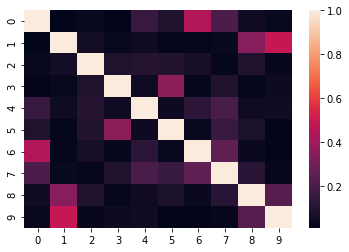

Key:
0 
Cancer development and progression result from somatic evolution by an accumulation of genomic alterations. The effects of those alterations on the fitness of somatic cells lead to evolutionary adaptations such as increased cell proliferation, angiogenesis, and altered anticancer drug responses. However, there are few general mathematical models to quantitatively examine how perturbations of a single gene shape subsequent evolution of the cancer genome. In this study, we proposed the gene gravity model to study the evolution of cancer genomes by incorporating the genome-wide transcription and somatic mutation profiles of ~3,000 tumors across 9 cancer types from The Cancer Genome Atlas into a broad gene network. We found that somatic mutations of a cancer driver gene may drive cancer genome evolution by inducing mutations in other genes. This functional consequence is often generated by the combined effect of genetic and epigenetic (e.g., chromatin regulation) alterations. By qu

In [18]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

I'm glad I finally got this model to work, but it isn't a good model for this data. 

### Supervised Learning Models to Predict Outcomes
I will use the BOW features to predict outcomes using Radom Forest Classifier, Logistic Regression, and Gradient Boosting Classifier to see which best predicts the topic of the sentence.

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9336283185840708

Test set score: 0.7682119205298014


In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(226, 1527) (226,)
Training set score: 0.9424778761061947

Test set score: 0.8145695364238411


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9336283185840708

Test set score: 0.8079470198675497


All three models had approximately the same accuracy scores for the training set.  The logistic regression model had the highest score for the test set.  I will use this model to optimize the predictions.

#### Optimizing Logistic Regression Model
Using the Logisitic Regression default model, which had the highest accuracy on the test set, I will attempt to increase the accuracy of the model.

First, I noticed that there were only around 1500 common words (eventhough the function specifies that there can be 2000 common words.  I will try reducing the number of common words used by the function to reduce the overfitting of the model.

In [22]:
def bag_of_words2(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_punct
               and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(1000)]


Next, I also think that I don't have enough entries to go off of, so I will repeat the get request to get the next entries in the search to add to the existing data.

In [23]:
response1b = requests.get(r'http://api.plos.org/search?q=title:"cancer"&fl=abstract&wt=json&api_key=51bQhx63o6--UjRBhkHb&start=10&rows=20')
response2b = requests.get(r'http://api.plos.org/search?q=title:"HIV"&fl=abstract&wt=json&api_key=51bQhx63o6--UjRBhkHb&start=10&rows=20')
response3b = requests.get(r'http://api.plos.org/search?q=title:"heart disease"&fl=abstract&wt=json&api_key=51bQhx63o6--UjRBhkHb&start=10&rows=20')

Pulling JSON data into usable data

In [24]:
cancer_raw2 = response1b.json()
hiv_raw2 = response2b.json()
heart_raw2 = response3b.json()

Pulling out just the abstracts of each article into one string. 

In [25]:
for article in cancer_raw2['response']['docs']:
    art = re.sub(r'[\[\]]','', str(article['abstract']))
    cancer = cancer + art

cancer[0:200]

"'\\nSocietal perceptions may factor into the high rates of nontreatment in patients with lung cancer. To determine whether bias exists toward lung cancer, a study using the Implicit Association Test me"

In [26]:
for article in hiv_raw2['response']['docs']:
    art = re.sub(r'[\[\]]','', str(article['abstract']))
    hiv = hiv + art

hiv[0:200]

"'Background: Whether spontaneous low levels of HIV-1 RNA in blood plasma correlate with low levels of HIV-1 RNA in seminal plasma has never been investigated in HIV controller (HIC) men so far. Method"

In [27]:
for article in heart_raw2['response']['docs']:
    art = re.sub(r'[\[\]]','', str(article['abstract']))
    heart = heart + art

heart[0:200]

"'\\nThere are 16.5 million newborns in China annually. However, the incidence of congenital heart disease (CHD) has not been evaluated. In 2004, we launched an active province-wide hospital-based CHD r"

In [28]:
cancer_clean2 = text_cleaner(cancer)
hiv_clean2 = text_cleaner(hiv)
heart_clean2 = text_cleaner(heart)

In [29]:
cancer_doc2 = nlp(cancer_clean2)
hiv_doc2 = nlp(hiv_clean2)
heart_doc2 = nlp(heart_clean2)

Splitting each topic into individual sentences for processing.

In [30]:
cancer_sents2 = [[sent, 'Cancer'] for sent in cancer_doc2.sents]
hiv_sents2 = [[sent, 'HIV'] for sent in hiv_doc2.sents]
heart_sents2 = [[sent, 'Heart'] for sent in heart_doc2.sents]

sentences2 = pd.DataFrame(cancer_sents2 + hiv_sents2 + heart_sents2)
sentences2.head()
print(len(sentences2))

1162


Identifying common words for the new set of sentences.

In [31]:
cancerwords2 = bag_of_words2(cancer_doc2)
hivwords2 = bag_of_words2(hiv_doc2)
heartwords2 = bag_of_words2(heart_doc2)

common_words2 = set(cancerwords2 + heartwords2 + hivwords2)
len(common_words2)

2123

Creating features for common words.

In [32]:
word_counts2 = bow_features(sentences2, common_words2)
word_counts2.head()

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500
Processing row 600
Processing row 700
Processing row 800
Processing row 900
Processing row 1000
Processing row 1100


,neovascularization,subset,n,prognostic,recruit,great,asia,evolutionary,prevalent,generation,...,motility,screening,attrition,infant,hypothesis,implication,routinely,male,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(nSocietal, perceptions, may, factor, into, th...",Cancer
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(To, determine, whether, bias, exists, toward,...",Cancer
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Participants, were, primarily, recruited, fro...",Cancer
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Explicit, attitudes, regarding, lung, and, br...",Cancer
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Participants’, responses, to, descriptive, an...",Cancer


Adding sentence length as a feature.

In [33]:
word_counts2['sent_length'] = word_counts2.text_sentence.map(lambda x: len(x)) 

Modeling using this new set of features on the expanded set of sentences.

In [34]:
Y2 = word_counts2['text_source']
X2 = np.array(word_counts2.drop(['text_sentence','text_source'], 1))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                    Y2,
                                                    test_size=0.4,
                                                    random_state=0)

In [35]:
lr2 = LogisticRegression()
train = lr2.fit(X_train2, y_train2)
print(X_train2.shape, y_train2.shape)
print('Training set score:', lr2.score(X_train2, y_train2))
print('\nTest set score:', lr2.score(X_test2, y_test2))

(697, 2124) (697,)
Training set score: 0.9383070301291249

Test set score: 0.864516129032258


The test set score decreased by 0.006.  Clearly throwing more data at the model did not increase the fit of the model.

In [38]:
abstract_list2 = []
for topic in [cancer_raw2, hiv_raw2, heart_raw2]:
    for article in topic['response']['docs']:
        abstract_list2 = abstract_list2 + article['abstract']

Identifying variables and applying the vectorizer.

In [42]:
from sklearn.model_selection import train_test_split

X2 = abstract_list2

X_train2, X_test2 = train_test_split(X2, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer(encoding='ASCII',
                             max_df=0.7, # drop words that occur in more than half the paragraphs
                             min_df=4, # only use words that appear at least four times
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
abstract_tfidf2=vectorizer.fit_transform(abstract_list2)
print("Number of features: %d" % abstract_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf2, X_test_tfidf2 = train_test_split(abstract_tfidf2, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr2 = X_train_tfidf2.tocsr()

#number of paragraphs
n = X_train_tfidf_csr2.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara2 = [{} for _ in range(0,n)]
#List of features
terms2 = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr2.nonzero()):
    tfidf_bypara2[i][terms2[j]] = X_train_tfidf_csr2[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train2[5])
print('Tf_idf vector:', tfidf_bypara2[5])

Number of features: 143
Original sentence: 
Great strides have been made in understanding the evolutionary history of simian immunodeficiency virus (SIV) and the zoonoses that gave rise to HIV-1 and HIV-2. What remains unknown is how long these SIVs had been circulating in non-human primates before the transmissions to humans. Here, we use relaxed molecular clock dating techniques to estimate the time of most recent common ancestor for the SIVs infecting chimpanzees and sooty mangabeys, the reservoirs of HIV-1 and HIV-2, respectively. The date of the most recent common ancestor of SIV in chimpanzees is estimated to be 1492 (1266–1685), and the date in sooty mangabeys is estimated to be 1809 (1729–1875). Notably, we demonstrate that SIV sequences sampled from sooty mangabeys possess sufficient clock-like signal to calibrate a molecular clock; despite the differences in host biology and viral dynamics, the rate of evolution of SIV in sooty mangabeys is indistinguishable from that of its 

This looks slightly better with more data. 

Now, let's run the data reducer to find the explained variance ratio. 

In [43]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd2= TruncatedSVD(130)
lsa2 = make_pipeline(svd2, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa2 = lsa2.fit_transform(X_train_tfidf2)

variance_explained2=svd2.explained_variance_ratio_
total_variance2 = variance_explained2.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component2=pd.DataFrame(X_train_lsa2,index=X_train2)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component2.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 100.00000000000004
Component 0:
Objectives: Nucleoside reverse transcriptase inhibitors (NRTIs) used in HIV antiretroviral therapy can inhibit human telomerase reverse transcriptase. We therefore investigated whether in utero or childhood exposure to NRTIs affects leukocyte telomere length (LTL), a marker of cellular aging. Methods: In this cross-sectional CARMA cohort study, we investigated factors associated with LTL in HIV -1-infected (HIV+) children (n = 94), HIV-1-exposed uninfected (HEU) children who were exposed to antiretroviral therapy (ART) perinatally (n = 177), and HIV-unexposed uninfected (HIV−) control children (n = 104) aged 0–19 years. Univariate followed by multivariate linear regression models were used to examine relationships of explanatory variables with LTL for: a) all subjects, b) HIV+/HEU children only, and c) HIV+ children only. Results: After adjusting for age and gender, there was no difference in LTL between the 3

This is STILL overfitting like crazy - variance explained OVER 100%. 

My hypothesis is that this data in paragraph form doesn't work for these models - there are too many words per paragraph to get a good association with the topic. If I were to do this again, I would use topics or authors that have fewer content-specific words that are not repeated in a text or that are isolated to just that content. 